# Median Combination Pedagogy
### Week of 3.29.2018

In [1]:
# python 2/3 compatibility
from __future__ import print_function

# numerical python
import numpy as np

# file management tools
import glob
import os

# good module for timing tests
import time

# plotting stuff
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
cmap = mpl.cm.viridis

%matplotlib inline

# ability to read/write fits files
from astropy.io import fits

# fancy image combination technique
from astropy.stats import sigma_clipping

# median absolute deviation: for photometry
#from astropy.stats import mad_std

# photometric utilities
#from photutils import DAOStarFinder,aperture_photometry, CircularAperture, CircularAnnulus

# import a library for generating pseudo random numbers
# [there is great computer science theory on 'random' numbers, check it out!]
from numpy import random 

In [2]:
# make the definitions for reading in images accessible in this notebook.
from HDI_io import *

In [3]:
# load up shifting methods
from shift_methods import *

### Part 1: Distribution Basics

Topics:
1. Median selection
2. Small number statistics

We'll start by imagining these in one dimension.

Draw 10000 samples from a normal distribution (an approximation of the background noise) and visualizing.

In [4]:
# set the parameters for the normal distribution
mean = 0.5
sigma = 0.1

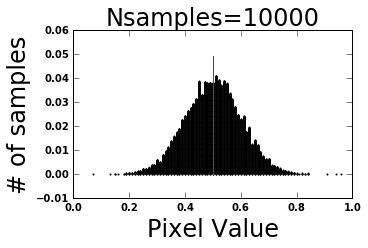

In [5]:
# we'll use random.random([size]), which returns a value on the interval [0.,1.)
# [that means 0 is allowed, but 1 is not: 'half-open']
# scale this using a prefactor, if desired


nsamples = 10000

# draw the values and 'bin' to 0.01 increments
randvals = np.round(random.normal(mean,sigma,nsamples),2)


# here's a cute method to make a pseudo histogram because of rounding
rand_y_vals = np.zeros_like(randvals)

for x in range(1,len(randvals)):
    rand_y_vals[x] = len(np.where(randvals[0:x] == randvals[x])[0])

    
# visualize
plt.figure(figsize=(5,3))

# render the points, normalizing to 1
plt.scatter(randvals,rand_y_vals/nsamples,color='black',s=1.)

# draw the median line and the theoretical median
plt.plot([np.median(randvals),np.median(randvals)],[0.,1.2*np.max(rand_y_vals/nsamples)],color='gray',lw=1.)
plt.plot([mean,mean],[0.,1.2*np.max(rand_y_vals/nsamples)],color='red',lw=1.)


plt.xlim(mean-5*sigma,mean+5*sigma)

plt.title('Nsamples={}'.format(nsamples),size=24)
plt.xlabel('Pixel Value',size=24)
plt.ylabel('# of samples',size=24)

Obviously, this is not totally smooth, even at this sample number. What happens if we decrease the number of samples?

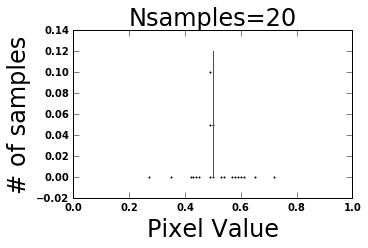

In [6]:
# identical to above, but with fewer samples

nsamples = 20

randvals = np.round(random.normal(mean,sigma,nsamples),2)

# here's a cute method to make a pseudo histogram
rand_y_vals = np.zeros_like(randvals)

for x in range(1,len(randvals)):
    rand_y_vals[x] = len(np.where(randvals[0:x] == randvals[x])[0])

    
plt.figure(figsize=(5,3))
plt.scatter(randvals,rand_y_vals/nsamples,color='black',s=1.)

# calculated median
plt.plot([np.median(randvals),np.median(randvals)],[0.,1.2*np.max(rand_y_vals/nsamples)],color='gray',lw=1.)

# theoretical median
plt.plot([mean,mean],[0.,1.2*np.max(rand_y_vals/nsamples)],color='red',lw=1.)



plt.xlim(mean-5*sigma,mean+5*sigma)

plt.title('Nsamples={}'.format(nsamples),size=24)
plt.xlabel('Pixel Value',size=24)
plt.ylabel('# of samples',size=24)

We can empirically check the convergence of the samples to the true value by drawing samples repeatedly and computing the median.

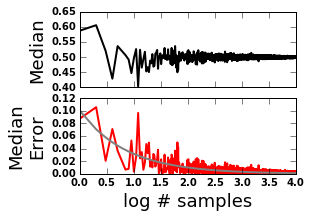

In [7]:

samplenums = np.arange(1,10000,1)
randvals_median = np.zeros(len(samplenums))

for indx,val in enumerate(samplenums):
    randvals_median[indx] = np.median(random.normal(mean,sigma,val))


fig = plt.figure(figsize=(5,3))


ax1 = fig.add_axes([0.2,0.6,0.6,0.35])
ax2 = fig.add_axes([0.2,0.2,0.6,0.35])

ax1.plot(np.log10(samplenums),randvals_median,color='black')
ax1.set_ylabel('Median',size=18)
ax1.set_xticklabels(())

ax2.plot(np.log10(samplenums),np.abs(randvals_median-0.5),color='red')
ax2.plot(np.log10(samplenums),0.1/(np.sqrt(samplenums)),color='gray')



ax2.set_xlabel('log # samples',size=18)
ax2.set_ylabel('Median\nError',size=18)

Unfortunately, we are almost always in the very low number region (so we still have plenty of noise). But, now we can start to see why deep images will start to minimize background noise!

Therefore, we want to do something like this at every point on the sky: take many observations and calculate the median. We do this at each pixel point in some fiducial image, that we have matched many other images to spatially.

But, we can do a little better. Enter sigma clipping.



### Part 1: Sigma Clipping

Let's grab a well-sample histogram of values, as above:

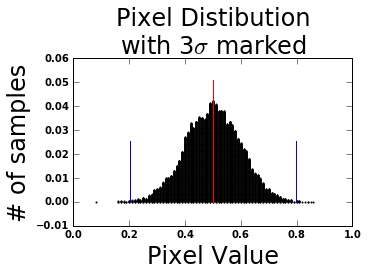

In [8]:
nsamples = 10000

randvals = np.round(random.normal(0.5,0.1,nsamples),2)

# here's a cute method to make a pseudo histogram
rand_y_vals = np.zeros_like(randvals)

for x in range(1,len(randvals)):
    rand_y_vals[x] = len(np.where(randvals[0:x] == randvals[x])[0])

    
plt.figure(figsize=(5,3))

plt.scatter(randvals,rand_y_vals/nsamples,color='black',s=1.)

median_value = np.median(randvals)
standard_deviation_value = np.std(randvals)

plt.plot([median_value,median_value],[0.,1.2*np.max(rand_y_vals/nsamples)],color='red',lw=1.)
plt.plot([median_value-3.*standard_deviation_value,median_value-3.*standard_deviation_value],\
         [0.,0.6*np.max(rand_y_vals/nsamples)],color='blue',lw=1.)
plt.plot([median_value+3.*standard_deviation_value,median_value+3.*standard_deviation_value],\
         [0.,0.6*np.max(rand_y_vals/nsamples)],color='blue',lw=1.)


# calculated median
plt.plot([median_value,median_value],[0.,1.2*np.max(rand_y_vals/nsamples)],color='gray',lw=1.)

# theoretical median
plt.plot([mean,mean],[0.,1.2*np.max(rand_y_vals/nsamples)],color='red',lw=1.)



plt.xlim(mean-5*sigma,mean+5*sigma)





plt.title('Pixel Distibution\nwith 3$\sigma$ marked',size=24)
plt.xlabel('Pixel Value',size=24)
plt.ylabel('# of samples',size=24)

Now we'd elimate anything to the left and right of the 3$\sigma$ values as being outliers.

This doesn't seem very important (and indeed, if we decrease nsample, we often won't even get fluxes out there). However, occasionally have a pixel value that is drawn from a totally different distribution. That is, another distribution may interlope with some frequency. Let's model it!

In [9]:
# draw the distribution as per usual
nsamples = 1000

randvals = np.round(random.normal(0.5,0.1,nsamples),2)



In [10]:

# now, some fraction of the time, a large flux is added
# this is a cosmic ray, with a different
cosmic_ray_mean = 0.9
cosmic_ray_sigma = 0.2
probability_of_cosmic_ray = 0.02

for x in range(0,nsamples):
    if random.random() < probability_of_cosmic_ray:
        randvals[x] += np.round(random.normal(cosmic_ray_mean,cosmic_ray_sigma),2)




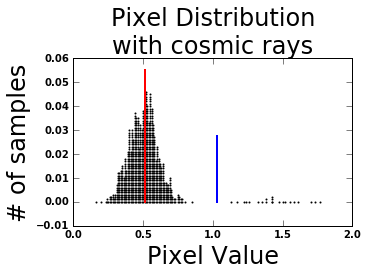

In [11]:
# plot as normal
rand_y_vals = np.zeros_like(randvals)

for x in range(1,len(randvals)):
    rand_y_vals[x] = len(np.where(randvals[0:x] == randvals[x])[0])

    
plt.figure(figsize=(5,3))
plt.scatter(randvals,rand_y_vals/nsamples,color='black',s=1.)

median_value = np.median(randvals)
standard_deviation_value = np.std(randvals)

plt.plot([median_value,median_value],[0.,1.2*np.max(rand_y_vals/nsamples)],color='red',lw=2.)
plt.plot([median_value-3.*standard_deviation_value,median_value-3.*standard_deviation_value],\
         [0.,0.6*np.max(rand_y_vals/nsamples)],color='blue',lw=2.)
plt.plot([median_value+3.*standard_deviation_value,median_value+3.*standard_deviation_value],\
         [0.,0.6*np.max(rand_y_vals/nsamples)],color='blue',lw=2.)






plt.xlim(0.,2.)
plt.title('Pixel Distribution\nwith cosmic rays',size=24)
plt.xlabel('Pixel Value',size=24)
plt.ylabel('# of samples',size=24)

Even 2% can be annoying, and we'd want to eliminate them. Note that they also throw the standard deviation off! We'll exploit this principle in a minute to find cosmic rays.

Luckily, it is more obvious if the added flux is large compared to the signal (as is the case for cosmic rays).

### Part 2: Real Data

Let's grab some real data and investigate how this works in practice.

In [12]:
data_dir = 'sample_data/'

obj_files = glob.glob(data_dir+'*o00*')
print('Using files:',obj_files)

phdr = fits.getheader(obj_files[0],0)
data = np.zeros([int(phdr['IMNAXIS2']),int(phdr['IMNAXIS1']),len(obj_files)])

for indx,infile in enumerate(obj_files):
    data[:,:,indx] = fits.getdata(infile)[0:phdr['IMNAXIS2'],0:phdr['IMNAXIS1']] - \
                     np.nanmedian(fits.getdata(infile)[0:4150,phdr['IMNAXIS1']:4150])


Using files: ['sample_data/c7451t0059o00.fits.gz', 'sample_data/c7451t0060o00.fits.gz', 'sample_data/c7451t0061o00.fits.gz']


In [13]:
#
# do the cross correlations and shift the arrays
#

shifted_data = np.zeros([int(phdr['IMNAXIS2']),int(phdr['IMNAXIS1']),len(obj_files)])

# first image is the fiducial to match to
shifted_data[:,:,0] = data[:,:,0]

for indx in range(1,len(obj_files)):
    xshift,yshift = cross_image(data[:,:,0],data[:,:,indx],boxsize=3000)
    print('Xshift={}, Yshift={}'.format(np.round(xshift,2),np.round(yshift,2)))
    
    # note that these are reversed owing to how HDI stores axes
    shifted_data[:,:,indx] = shift_image(data[:,:,indx],xshift,yshift)
    
    
# supersede old data:
data = shifted_data

Xshift=-0.97, Yshift=0.11
Xshift=-1.32, Yshift=-1.16


Let's take a look at a small 5x5 sample of the images to try and understand what the median is actually doing.

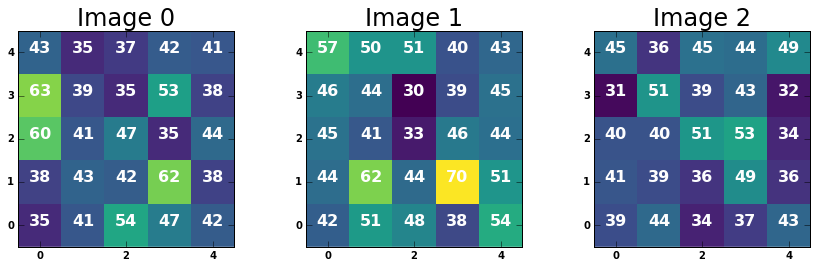

In [14]:
fig = plt.figure(figsize=(16,12))

ax0 = fig.add_axes([0.2,0.2,0.25,0.25])
ax1 = fig.add_axes([0.45,0.2,0.25,0.25])
ax2 = fig.add_axes([0.7,0.2,0.25,0.25])

xmin = 400
xmax = 5

# set color minimum, maximum
vmin=np.min(data[xmin:xmin+xmax,xmin:xmin+xmax,:])
vmax=np.max(data[xmin:xmin+xmax,xmin:xmin+xmax,:])

ax0.imshow(data[xmin:xmin+xmax,xmin:xmin+xmax,0],origin='lower',vmin=vmin,vmax=vmax,cmap=cmap,interpolation='none')
ax1.imshow(data[xmin:xmin+xmax,xmin:xmin+xmax,1],origin='lower',vmin=vmin,vmax=vmax,cmap=cmap,interpolation='none')
ax2.imshow(data[xmin:xmin+xmax,xmin:xmin+xmax,2],origin='lower',vmin=vmin,vmax=vmax,cmap=cmap,interpolation='none')

ax0.set_xticks([0,2,4])
ax1.set_xticks([0,2,4])
ax2.set_xticks([0,2,4])

ax0.set_title('Image 0',size=24)
ax1.set_title('Image 1',size=24)
ax2.set_title('Image 2',size=24)

# this is convolted, but must be like this to plot the numbers correctly!
for x in range(xmax-1,-1,-1):
    for y in range(0,xmax):
        ax0.text(y,x,int(data[xmin+x,xmin+y,0]),size=16,color='white',ha='center')
        ax1.text(y,x,int(data[xmin+x,xmin+y,1]),size=16,color='white',ha='center')
        ax2.text(y,x,int(data[xmin+x,xmin+y,2]),size=16,color='white',ha='center')

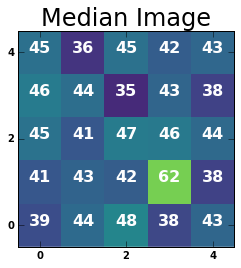

In [15]:
fig = plt.figure(figsize=(5,5))

ax0 = fig.add_axes([0.2,0.2,0.6,0.6])


median_data = np.median(data[xmin:xmin+xmax,xmin:xmin+xmax,:],axis=2)

ax0.imshow(median_data,origin='lower',vmin=vmin,vmax=vmax,cmap=cmap,interpolation='none')

ax0.set_xticks([0,2,4])
ax0.set_yticks([0,2,4])

ax0.set_title('Median Image',size=24)

# this is convolted, but must be like this to plot the numbers correctly!
for x in range(xmax-1,-1,-1):
    for y in range(0,xmax):
        ax0.text(y,x,int(median_data[x,y]),size=16,color='white',ha='center')


This is much closer to a uniform field!

We can go one step further and make a two-dimensional sigma map for each image.

In [16]:
# make a two-dimensional median and standard deviation map
median_field = np.median(data,axis=2)
std_field = np.std(data,axis=2)


In [17]:
# make a map of the sigma values for each pixel

data_sigma = np.zeros_like(data)

for indx in range(0,len(obj_files)):
    
    data_sigma[:,:,indx] = (data[:,:,indx] - median_field)/std_field
    
    # blank out bad values
    data_sigma[:,:,indx][~np.isfinite(data_sigma[:,:,indx])] = 0.

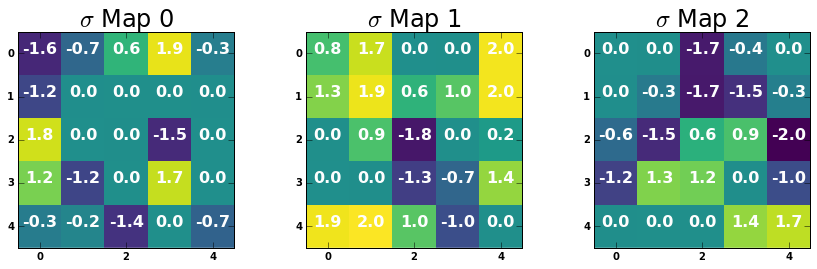

In [18]:
fig = plt.figure(figsize=(16,12))


ax0 = fig.add_axes([0.2,0.2,0.25,0.25])
ax1 = fig.add_axes([0.45,0.2,0.25,0.25])
ax2 = fig.add_axes([0.7,0.2,0.25,0.25])


vmin=np.min(data_sigma[xmin:xmin+xmax,xmin:xmin+xmax,:])
vmax=np.max(data_sigma[xmin:xmin+xmax,xmin:xmin+xmax,:])


ax0.imshow(data_sigma[xmin:xmin+xmax,xmin:xmin+xmax,0],vmin=vmin,vmax=vmax,cmap=cmap,interpolation='none')
ax1.imshow(data_sigma[xmin:xmin+xmax,xmin:xmin+xmax,1],vmin=vmin,vmax=vmax,cmap=cmap,interpolation='none')
ax2.imshow(data_sigma[xmin:xmin+xmax,xmin:xmin+xmax,2],vmin=vmin,vmax=vmax,cmap=cmap,interpolation='none')

ax0.set_xticks([0,2,4])
ax1.set_xticks([0,2,4])
ax2.set_xticks([0,2,4])

ax0.set_title('$\sigma$ Map 0',size=24)
ax1.set_title('$\sigma$ Map 1',size=24)
ax2.set_title('$\sigma$ Map 2',size=24)


for x in range(0,xmax):
    for y in range(0,xmax):
        ax0.text(y,x,np.round(data_sigma[xmin+x,xmin+y,0],1),size=16,color='white',ha='center')
        ax1.text(y,x,np.round(data_sigma[xmin+x,xmin+y,1],1),size=16,color='white',ha='center')
        ax2.text(y,x,np.round(data_sigma[xmin+x,xmin+y,2],1),size=16,color='white',ha='center')

The pixels with '0.0' will be the accepted pixels. Why?

Hey, did you know that you can plot in 3d?

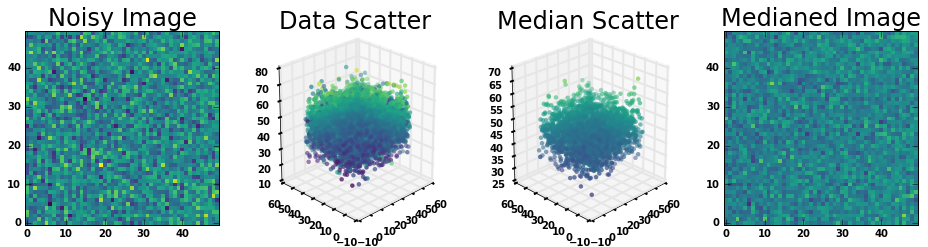

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,4))

xmin = 400

# let's zoom out a little
xmax = 50


median_data = np.median(data[xmin:xmin+xmax,xmin:xmin+xmax,:],axis=2)



xvals = np.arange(0,xmax,1)
X,Y = np.meshgrid(xvals,xvals)

vmin=np.min(data[xmin:xmin+xmax,xmin:xmin+xmax,:])
vmax=np.max(data[xmin:xmin+xmax,xmin:xmin+xmax,:])

ax0 = fig.add_subplot(1,4,1)
ax0.imshow(data[xmin:xmin+xmax,xmin:xmin+xmax,0],vmin=vmin,vmax=vmax,origin='lower',cmap=cmap,interpolation='none')
ax0.set_title('Noisy Image',size=24)


ax0 = fig.add_subplot(1,4,2, projection='3d')
ax0.scatter(X,Y,data[xmin:xmin+xmax,xmin:xmin+xmax,0],c=data[xmin:xmin+xmax,xmin:xmin+xmax,1],cmap=cmap,edgecolor='none',vmin=vmin,vmax=vmax)
ax0.scatter(X,Y,data[xmin:xmin+xmax,xmin:xmin+xmax,1],c=data[xmin:xmin+xmax,xmin:xmin+xmax,1], cmap=cmap,edgecolor='none',vmin=vmin,vmax=vmax)
ax0.scatter(X,Y,data[xmin:xmin+xmax,xmin:xmin+xmax,2],c=data[xmin:xmin+xmax,xmin:xmin+xmax,2], cmap=cmap,edgecolor='none',vmin=vmin,vmax=vmax)
ax0.set_title('Data Scatter',size=24)



# set the viewing angle
ax0.view_init(22, -135)

ax1 = fig.add_subplot(1,4,3, projection='3d')
ax1.scatter(X,Y,median_data,c=median_data,cmap=cmap,edgecolor='none',vmin=vmin,vmax=vmax)

ax1.view_init(22, -135)
ax1.set_title('Median Scatter',size=24)

ax2 = fig.add_subplot(1,4,4)
ax2.imshow(median_data,vmin=vmin,vmax=vmax,origin='lower',cmap=cmap,interpolation='none')
_ = ax2.set_title('Medianed Image',size=24)

Does sigma clipping actually work?

Let's go back to the standard deviation map and spot check some of the large values to see what exactly we are getting rid of by taking the median:

In [20]:
w = np.where(std_field > 10000.)

# spot check  10
for indx in range(100,110):
    pix_vals = np.round(data[w[0][indx],w[1][indx]],0)
    print(pix_vals[pix_vals.argsort()])

[  2073.  55037.  64976.]
[  2596.   8023.  61346.]
[  3110.   9159.  53838.]
[ 13943.  25793.  57793.]
[  4204.   9101.  56210.]
[ 26928.  45225.  59656.]
[  4488.   9781.  60405.]
[  4808.  10328.  57717.]
[  5284.  10831.  41306.]
[ 12125.  59614.  62673.]


In [21]:
# spot check 10: convert to sigmas
for indx in range(100,110):
    
    pix_vals = data[w[0][indx],w[1][indx]]
    sigma_pix = np.std(pix_vals)
    median_pix = np.median(pix_vals)
    
    sorted_pix = pix_vals[pix_vals.argsort()]
    
    print(np.round(((sorted_pix-median_pix)/sigma_pix),2))

[-1.92  0.    0.36]
[-0.2   0.    2.01]
[-0.27  0.    1.97]
[-0.64  0.    1.73]
[-0.21  0.    2.01]
[-1.37  0.    1.08]
[-0.21  0.    2.01]
[-0.23  0.    2.  ]
[-0.35  0.    1.92]
[-2.05  0.    0.13]
